In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### GAN 모델 만들기

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# 이미지가 저장될 폴더가 없다면 생성
import os
if not os.path.exists("/content/gdrive/My Drive/deepLearning/gan_images"):
    os.makedirs("/content/gdrive/My Drive/deepLearning/gan_images")

In [ ]:
np.random.seed(3)
tf.random.set_seed(3)

In [ ]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))  # 겹괄호 주의
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 판별자로 넘기기 전 마지막엔 tanh

In [ ]:
# 판별자 모델 만들기

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [ ]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기

ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))

gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0  d_loss:0.4623  g_loss:0.3281
epoch:1  d_loss:0.5639  g_loss:0.0999
epoch:2  d_loss:0.6602  g_loss:0.0772
epoch:3  d_loss:0.5601  g_loss:0.1668
epoch:4  d_loss:0.5013  g_loss:0.3960
epoch:5  d_loss:0.4918  g_loss:0.6284
epoch:6  d_loss:0.5137  g_loss:0.7581
epoch:7  d_loss:0.5109  g_loss:0.7492
epoch:8  d_loss:0.4999  g_loss:0.7402
epoch:9  d_loss:0.4492  g_loss:0.6709
epoch:10  d_loss:0.4747  g_loss:0.6964
epoch:11  d_loss:0.5681  g_loss:0.6232
epoch:12  d_loss:0.5934  g_loss:0.6134
epoch:13  d_loss:0.5574  g_loss:0.5637
epoch:14  d_loss:0.5263  g_loss:0.7380
epoch:15  d_loss:0.5053  g_loss:0.7520
epoch:16  d_loss:0.4706  g_loss:0.6885
epoch:17  d_loss:0.4213  g_loss:0.4827
epoch:18  d_loss:0.4055  g_loss:0.3356
epoch:19  d_loss:0.3485  g_loss:0.3710
epoch:20  d_loss:0.3014  g_loss:0.5891
epoch:21  d_loss:0.2643  g_loss:0.6631
epoch:22  d_loss:0.2769  g_loss:0.4824
epoch:23  d_loss:0.3009  g_loss:0.3812
epoch:24  d_loss:0.2328  g_loss:0.5662
epoch:25  d_loss:0.3190  g_loss:0.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


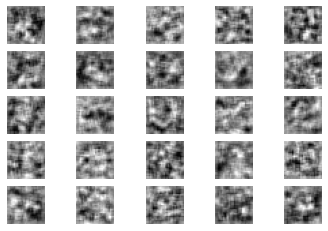

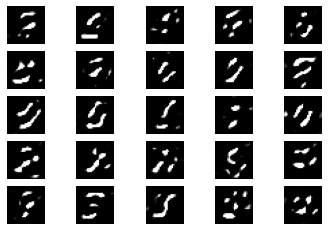

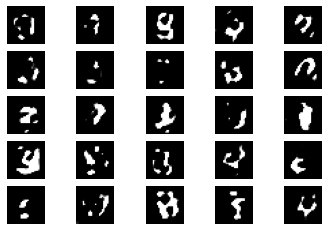

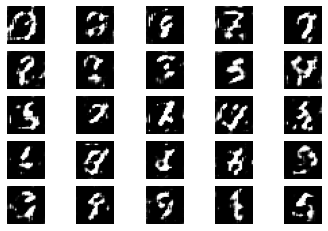

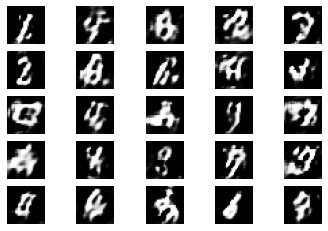

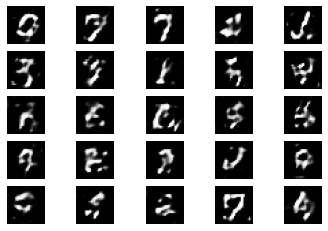

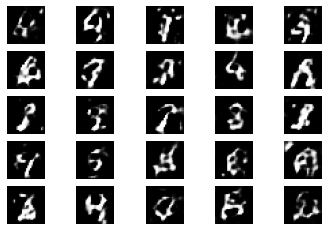

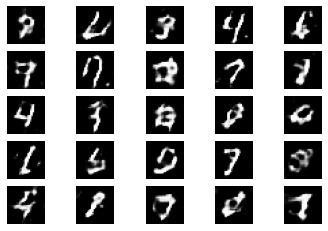

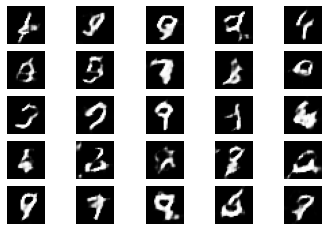

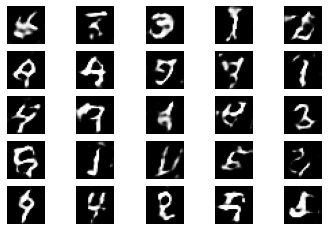

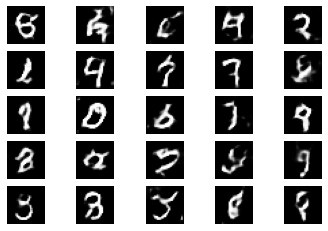

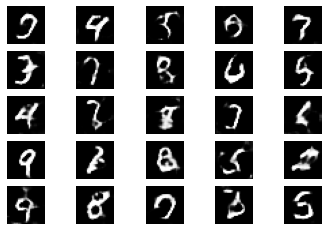

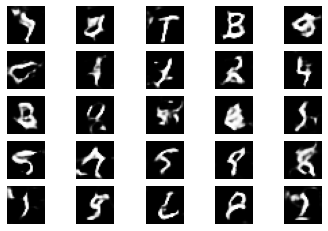

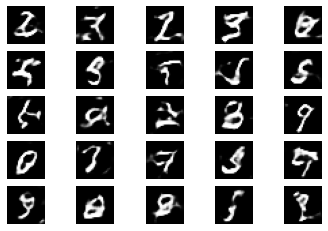

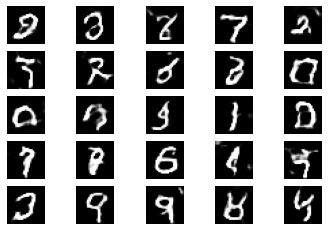

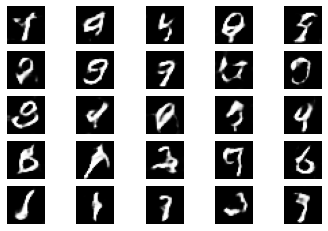

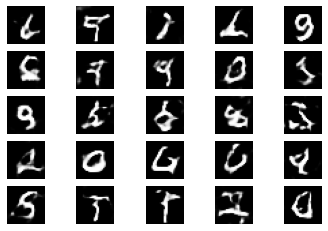

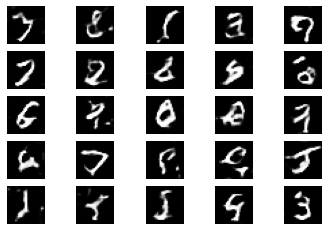

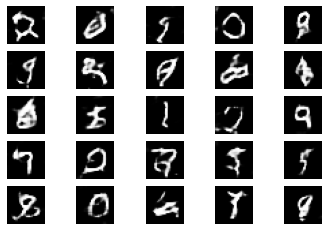

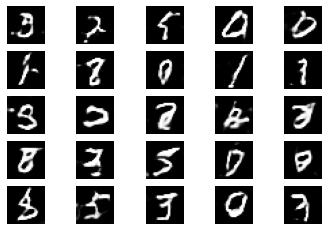

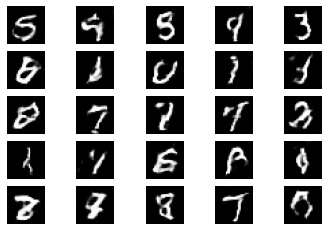

In [ ]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)


        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어 소스코드만 첨부합니다. 
        # 정해진 인터벌만큼 학습되면 그때 만들어진 이미지들을 gan_images 폴더에 저장하라는 뜻

          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("/content/gdrive/My Drive/deepLearning/gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.